In [52]:
import json
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import ternary
%matplotlib inline

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [53]:
# Class to store each tag coordinate data
class tagClass:
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [54]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [55]:
def getTags(rawData, nType):
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [56]:
trainTags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
testTags = getTags(raw15['0'], ['669', '671'])

In [57]:
bayerFilter = [["R", "G"],
               ["G", "B"]]
# Find Bayer filter pixel colour for given coordinate
def getBayer(x, y):
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [58]:
def getSnipPlot(tag):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    plt.imshow(photo[tagY:tagY2,tagX:tagX2],cmap='gray')
    plt.colorbar()
    # rect = patches.Rectangle((tag.getY()-tagY-5, tag.getX()-tagX-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    return photo[tagY:tagY2,tagX:tagX2]

In [59]:
def getPhoto(tag: tagClass):
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [60]:
def getPixels(t, photo):
    tagX, tagX2, tagY, tagY2 = t
    colourPixels = [[], [], []] # R G B
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                colourPixels[0].append(photo[py, px])
            elif col == 'G':
                colourPixels[1].append(photo[py, px])
            else:
                colourPixels[2].append(photo[py, px])
    totalSum = sum(colourPixels[0]) + sum(colourPixels[1]) + sum(colourPixels[2])
    return sum(colourPixels[0])/totalSum, sum(colourPixels[1])/totalSum, sum(colourPixels[2])/totalSum

In [61]:
xTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in trainTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    xTags.loc[len(xTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

xTrain, xTest, yTrain, yTest = train_test_split(xTags[["Red", "Green", "Blue"]], xTags["Label"], test_size=0.2)

In [62]:
yTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in testTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    yTags.loc[len(yTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

In [63]:
allTags = pd.concat([xTags, yTags])

array([[ 11,   2,  12,   3,  14,   3,  13,   3,  12,   2,  12,   3,  12,
          2,  12,   3],
       [  2,   4,   3,   4,   3,   4,   3,   4,   3,   4,   3,   4,   2,
          3,   2,   4],
       [ 11,   3,  12,   3,  13,   3,  12,   3,  11,   3,  11,   2,  11,
          2,  10,   2],
       [  2,   3,   3,   5,   3,   4,   3,   4,   2,   3,   3,   5,   3,
          4,   3,   3],
       [ 11,   3,  12,   3,  11,   3,  11,   4,  15,   4,  12,   3,  11,
          3,   9,   3],
       [  2,   4,   3,   5,   3,   4,   3,  17,   9,  21,   7,   7,   5,
          6,   5,   8],
       [  8,   2,  10,   2,  11,   3,  20,  16,  83,  26,  54,  11,  19,
          8,  16,  10],
       [  2,   3,   2,   4,   3,  10,  13,  57,  27,  65,  28,  26,  10,
         12,   9,  14],
       [  8,   2,  10,   2,   9,   5,  37,  28, 102,  36, 102,  22,  24,
         10,  19,  10],
       [  1,   3,   2,   3,   3,  12,  13,  59,  33,  72,  35,  41,  11,
         12,   9,  11],
       [  7,   1,   9,   2,  1

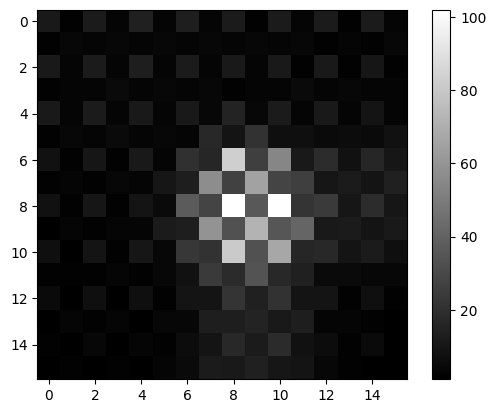

In [64]:
getSnipPlot(xTags["Tag"][0])

## Plot to RGB heatmap

In [65]:
def colorPoint(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

def plotHeatmap(asTuples, labels, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)#np.array(expected['002']))
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    plt.show()

In [66]:
scale = 30
# tagList = [0]
# sampleTags = allTags.loc[allTags["Label"].isin(tagList)]
# asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in sampleTags.iterrows()]
# labels = sampleTags["Label"]
# plotHeatmap(asTuples, labels, scale)

c:\Users\katie\AppData\Local\Programs\Python\Python311\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


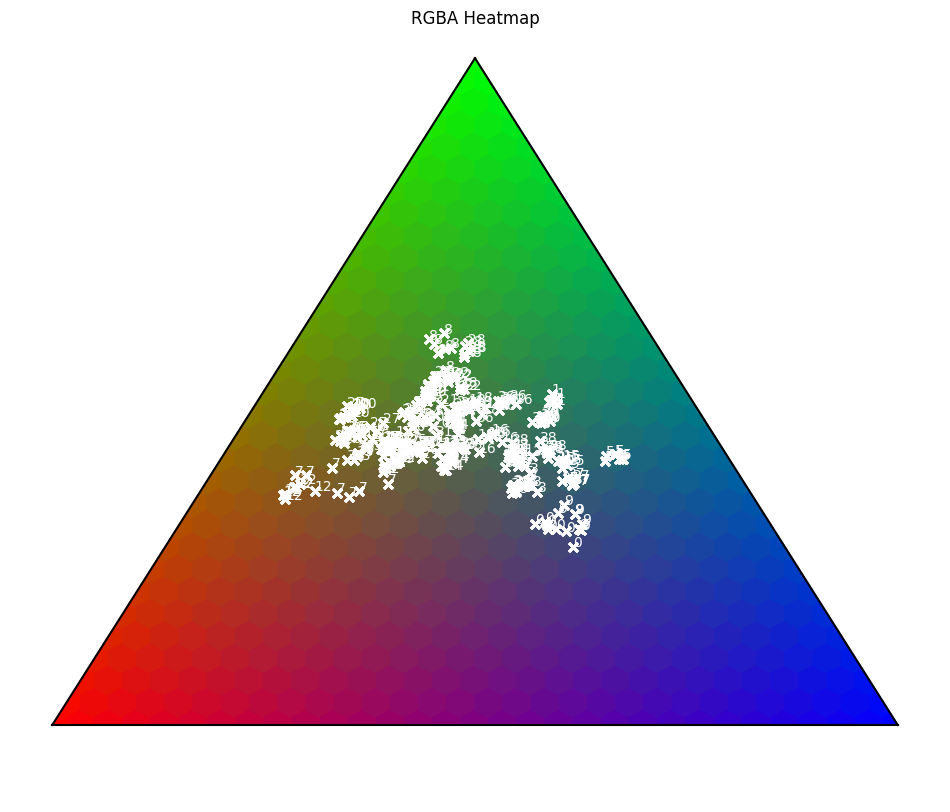

In [42]:
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in allTags.iterrows()]
labels = allTags["Label"]
plotHeatmap(asTuples, labels, scale)

## ML train/test

In [43]:
gnb = GaussianNB().fit(xTrain, yTrain)
gnbPred = gnb.predict(yTags[["Red", "Green", "Blue"]])

In [44]:
clf = svm.SVC().fit(xTrain, yTrain)
svmPred = clf.predict(yTags[["Red", "Green", "Blue"]])

In [45]:
# mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1).fit(xTrain, yTrain)
# mlpPred = mlp.predict(yTags[["Red", "Green"]])

In [46]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, name):
    print(name)
    print("Accuracy: ", accuracy_score(yTags["Label"], modelPred))
    print("F1: ", f1_score(yTags["Label"], modelPred, average='macro'))
    print("Precision: ", precision_score(yTags["Label"], modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(yTags["Label"], modelPred, average='macro'))
    print("MSE: ", mean_squared_error(yTags["Label"], modelPred), "\n")

In [47]:
scores(gnbPred, "GNB")
scores(svmPred, "SVM")
# scores(mlpPred, "MLP")

GNB
Accuracy:  0.4875
F1:  0.4723412698412698
Precision:  0.603042328042328
Recall:  0.4875
MSE:  143.4875 

SVM
Accuracy:  0.2875
F1:  0.1879279054279054
Precision:  0.44127946127946127
Recall:  0.2875
MSE:  213.9125 



## Random notes

In [48]:
# average colours from all images - normalise
# R/(R+G+B) G/(R+G+B)
# train model on colours & labels
# test model to classfiy other image labels

# maybe remove background mesh
# func pixel coords generated to show brightness
# psf tagxy brightness pf col, bg of col, pixel ->> pred cixel col -> SSE
# brightness for each col -> then loop all pixels then predict pixels -> SSE = func - true picel val

In [49]:
# run with smaller box around pixels - brightest as centre?
# bokeh out of focus width affected by distance?
# estimate brightness of bg?
# estimate width of brightest tags
# hexagonal bokeh - find centre of bokeh
# px, py, bi, hi, xi, yi per picture but width is same
# x y is centre of bokeh - tag coords
# 
# sum ( fn(px py xi yi hi w) - true px py ) ^2 ) for each pixel -> fn = guess pixel value
# sum that for all pictures - see notebook!!

## Cost function

In [50]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    dist = math.dist(tagCoord, pixelCoord)
    if dist>psfWidth+0.5:
           return bgBrightness
    elif dist<psfWidth-0.5:
        return tagBrightness
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))
# dist>w+0.5 -> bg
# dist<w-0.5 -> tag
# bg*(0.5 + dist - w)- tag*(dist - w - 0.5) ### check func for linear transition between bg and tag

#hessian = second derivative -> hess_inv shows variance of gaussian spread
# mcmc for distribution sampling


# def simulate_image(tagCoord, [tagBright_r, tagBright_g, tagBright_b], [bgBright_r, bgBright_g, bgBright_b], psfWidth, trueImg):
def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    pixel_value_guesses = []

    # loop over pixel coords for each colour...

    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # call simulate_pixel with the coords of the pixel and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord, t[colour], b[colour], psfWidth))
    return pixel_value_guesses


def cost_function(params, psfWidth, trueImg):
    tagCoord = [params[0], params[1]]
    tagBright = [params[2], params[3], params[4]]
    bgBright = [params[5], params[6], params[7]]
    # tagBright = params[2]
    # bgBright = params[3]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, psfWidth, trueImg.shape)
    # sum square error over all the pxiels between the true image and the simulate_image
    square_error = [(s - a)**2 for (s, a) in zip(pixel_value_guesses, trueImg)]
    return np.sum(square_error)

12119.0

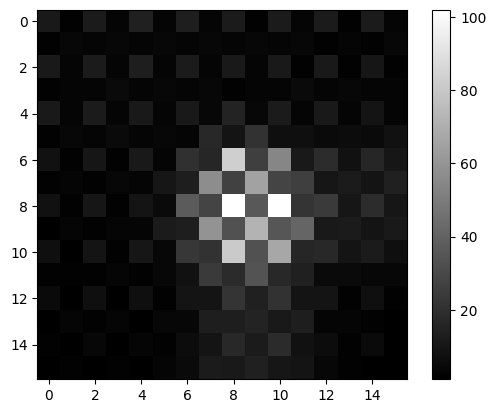

In [51]:
realImg = getSnipPlot(allTags['Tag'].iloc[0]) # clip this photo per tag
cost_function(np.array([0, 0, 12, 14, 5, 4, 6, 5]), 3, realImg)

In [67]:
initial_parameters = np.array([
    np.random.rand()*realImg.shape[0],
    np.random.rand()*realImg.shape[1], # tag location
    np.random.rand()*np.max(realImg), # intensity r
    np.random.rand()*np.max(realImg), # intensity g
    np.random.rand()*np.max(realImg), # intensity b
    np.random.rand()*np.min(realImg), # background r
    np.random.rand()*np.min(realImg), # background g
    np.random.rand()*np.min(realImg) # background b
])
minimize(cost_function, initial_parameters, args = (3, realImg))
# tag loc = middle (width/2), bg = 0,  intensity = largest val in pic

      fun: 58174.21093750021
 hess_inv: array([[ 9.84993102e-02,  2.47002249e-01,  1.52058178e-01,
         6.70707109e-02,  0.00000000e+00,  3.02742470e-05,
         7.29531166e-07,  0.00000000e+00],
       [ 2.47002249e-01,  9.32323833e-01, -4.16624328e-02,
        -1.83767097e-02,  0.00000000e+00, -8.29483509e-06,
        -1.99885108e-07,  0.00000000e+00],
       [ 1.52058178e-01, -4.16624328e-02,  9.74352000e-01,
        -1.13129698e-02,  0.00000000e+00, -5.10643284e-06,
        -1.23050995e-07,  0.00000000e+00],
       [ 6.70707109e-02, -1.83767097e-02, -1.13129698e-02,
         9.95010009e-01,  0.00000000e+00, -2.25234910e-06,
        -5.42786438e-08,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.02742470e-05, -8.29483509e-06, -5.10643284e-06,
        -2.25234910e-06,  0.00000000e+00,  3.90457972e-03,
        -3.69873047e-04,  0.00000000e

In [72]:
bestScore = np.inf
best = None
for restart in range(100):
    initial_parameters = np.array([
        np.random.rand()*realImg.shape[0],
        np.random.rand()*realImg.shape[1], # tag location
        np.random.rand()*np.max(realImg), # intensity r
        np.random.rand()*np.max(realImg), # intensity g
        np.random.rand()*np.max(realImg), # intensity b
        np.random.rand()*np.min(realImg), # background r
        np.random.rand()*np.min(realImg), # background g
        np.random.rand()*np.min(realImg) # background b
    ])
    res = minimize(cost_function, initial_parameters, args = (3, realImg))
    if res.fun < bestScore:
        bestScore = res.fun
        best = res
res = best

In [73]:
print(res)


      fun: 46927.470833333835
 hess_inv: array([[ 8.87285923e-05, -7.79443973e-06,  3.50229379e-04,
         1.37040818e-05,  0.00000000e+00, -1.71894249e-05,
        -1.68459793e-04,  0.00000000e+00],
       [-7.79443973e-06,  8.17756187e-05, -1.51926378e-04,
         4.55759156e-06,  0.00000000e+00, -3.21303692e-05,
        -8.73756093e-06,  0.00000000e+00],
       [ 3.50229379e-04, -1.51926378e-04,  1.19430450e-02,
         2.84187243e-04,  0.00000000e+00, -2.49459998e-03,
        -2.80436253e-03,  0.00000000e+00],
       [ 1.37040818e-05,  4.55759156e-06,  2.84187243e-04,
         1.55085453e-02,  0.00000000e+00, -1.32360663e-04,
        -1.16206698e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.71894249e-05, -3.21303692e-05, -2.49459998e-03,
        -1.32360663e-04,  0.00000000e+00,  1.56026053e-03,
         7.95730084e-04,  0.00000000

In [41]:
# find average of each colour
# try simulate the tag - compare how correct visually

In [89]:
res.hess_inv

array([[ 8.87285923e-05, -7.79443973e-06,  3.50229379e-04,
         1.37040818e-05,  0.00000000e+00, -1.71894249e-05,
        -1.68459793e-04,  0.00000000e+00],
       [-7.79443973e-06,  8.17756187e-05, -1.51926378e-04,
         4.55759156e-06,  0.00000000e+00, -3.21303692e-05,
        -8.73756093e-06,  0.00000000e+00],
       [ 3.50229379e-04, -1.51926378e-04,  1.19430450e-02,
         2.84187243e-04,  0.00000000e+00, -2.49459998e-03,
        -2.80436253e-03,  0.00000000e+00],
       [ 1.37040818e-05,  4.55759156e-06,  2.84187243e-04,
         1.55085453e-02,  0.00000000e+00, -1.32360663e-04,
        -1.16206698e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.71894249e-05, -3.21303692e-05, -2.49459998e-03,
        -1.32360663e-04,  0.00000000e+00,  1.56026053e-03,
         7.95730084e-04,  0.00000000e+00],
       [-1.68459793e-04, -8.737560

In [76]:
tag_loc = [res.x[0], res.x[1]] # tag location
intensity = [res.x[2], res.x[3], res.x[4]] # intensity rgb
background = [res.x[5], res.x[6], res.x[7]] # background rgb
tag_loc, intensity, background

([2.0660784766804263, 8.046174070664955],
 [26.625005025128072, 18.90624833996742, 44.809599635897676],
 [7.1624998183227655, 5.5520835019944155, 0.021597266033788753])

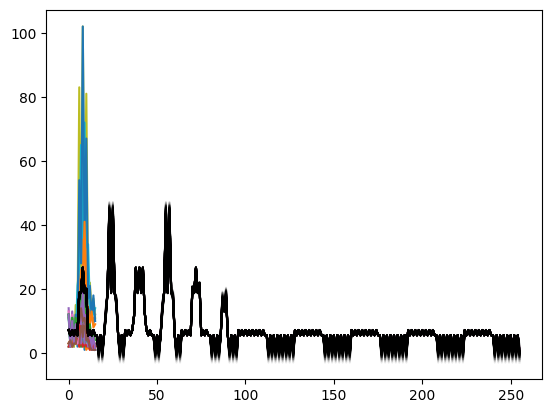

In [88]:
guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
plt.plot(realImg)
plt.plot(guess)
wsamps = np.random.multivariate_normal(res.x, res.hess_inv, 100)

for w in wsamps:
    tag_loc, intensity, background = [w[0], w[1]], [w[2], w[3], w[4]], [w[5], w[6], w[7]]
    guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
    plt.plot(guess, 'k-', alpha=0.1)

In [ ]:
# photoTags = getTags(raw15['0'], ['649'], 10)
# photo = getPhoto(photoTags[0])
# coords = [(tag.getX(), tag.getY()) for tag in photoTags]
# red, green, blue = zip(*(getPixels(tag.getSnipCoords(), photo) for tag in photoTags))
# red_bg, green_bg, blue_bg = getPixels((0, photo.shape[1]-1, 0, photo.shape[0]-1), photo)



In [ ]:
# cost_function(photo, coords, red, green, blue, red_bg, green_bg, blue_bg)
# scipy.optimize.minimize(cost_function, , args=(photo, coords, red, green, blue, red_bg, green_bg, blue_bg))
# scipy.optimize.minimize(cost_function, initial_parameters)

# calculate proportion of pixel in circle?

In [ ]:
# def perPixel(photo, colour):
#     fn(p, t, b, h, 5) - pixelColour(p, photo)